# Introduction

# Training DETR on Custom Dataset
Tutorial Video [link](https://www.youtube.com/watch?v=RkhXoj_Vvr4&lc=UgwHlStd7pa4KMszFQx4AaABAg&ab_channel=DeepReader)  
Code based on [End-to-end Object Detection with Transformer](https://github.com/facebookresearch/detr)

##Requirements

- Make sure runtime is set to GPU

##Step 1.

Clone repo from github and check requirements

In [1]:
import os

os.chdir('/content/')

# !rm -rf /content/detr_tutorial/

In [2]:
# mount drive to save checkpoints and access files on google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


%cd /content

Mounted at /content/drive/
/content


In [3]:
# thedeepreader is outdated
#!git clone https://github.com/thedeepreader/detr_tutorial

# This repo should be up-to-date with FB's updates, if not then post an issue - Neil
!git clone https://github.com/jjennyli/detr_tutorial.git

os.chdir('/content/detr_tutorial/detr/')

!pip install -qr requirements.txt

os.chdir('/content/')

Cloning into 'detr_tutorial'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 199 (delta 45), reused 45 (delta 45), pack-reused 150
Receiving objects: 100% (199/199), 134.27 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (88/88), done.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00


In [ ]:

%ls -l '/content/drive/MyDrive/DETR_Working/data/train' | grep 'jpg' | wc -l
%ls -l '/content/drive/MyDrive/DETR_Working/data/test' | grep 'jpg' | wc -l
%ls -l '/content/drive/MyDrive/DETR_Working/data/valid' | grep 'jpg' | wc -l

5082
318
636


## Remove Corrupted JPG Images and their corresponding TXT files
<b><u>NOTE</u>: Only needed to run if the datasets are updated with new images</b>

In [ ]:
from os import listdir
import cv2 as cv

bad_files = 0
for f in ['train', 'valid', 'test']:
  data = '/content/drive/MyDrive/DETR_Working/data/{}/'.format(f)
  for filename in listdir(data):
    if filename.endswith('.jpg'):
      im = cv.imread(data + filename)
      val = cv.haveImageReader(data + filename) # returns false if not readable by cv2
      if(not val):
        bad_files += 1
        print(f + "/" + filename)
        # remove files
        os.remove(data+filename)
        os.remove(data+filename.replace(".jpg", ".txt"))
print("Number of bad jpgs: ", bad_files)

Number of bad jpgs:  0


## Step 2. Download Pretrained Weights & Convert Dataset to COCO Format

##Download weights for transfer learning to speed up training



In [4]:
!gdown https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth

Downloading...
From: https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
To: /content/detr-r50-e632da11.pth
100% 167M/167M [00:00<00:00, 190MB/s]


In [5]:
!wget https://dl.fbaipublicfiles.com/detr/detr-r101-dc5-a2e86def.pth

--2023-05-22 23:30:18--  https://dl.fbaipublicfiles.com/detr/detr-r101-dc5-a2e86def.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.80, 99.84.160.46, 99.84.160.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242846568 (232M) [application/octet-stream]
Saving to: ‘detr-r101-dc5-a2e86def.pth’

detr-r101-dc5-a2e86 100%[===================>] 231.60M   219MB/s    in 1.1s    

2023-05-22 23:30:19 (219 MB/s) - ‘detr-r101-dc5-a2e86def.pth’ saved [242846568/242846568]



## **NOTE: Unless you either (1) Don't have COCO formatted data or (2) Updated your dataset, there is no need to re-run this function because it takes a long time to convert the data into COCO format.** Reuse COCO data to save time.

Edit face.py based on number of classes in your dataset


- Move to the dataset folder, and convert downloaded  dataset into COCO format




In [ ]:
%%writefile /content/detr_tutorial/dataset/face_to_coco.py
import re
import os
import cv2
import json
import itertools
import numpy as np
import glob
import scipy.io as sio
from pycocotools import mask as cocomask
from PIL import Image
import matplotlib.pyplot as plt

categories = []
items = ["supercategory",
        "name",
        "id"]

def makeCategories(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      name = l.strip()
      temp = {items[0]:"none",items[1]:name,items[2]:i}
      categories.append(temp)
  return categories

# Use classes.txt file here - this is used to label each object found in the image
categories = makeCategories("/content/drive/MyDrive/DETR_Working/data/classes.txt")

phases = ["train","valid","test"]
for phase in phases:
    root_path = "/content/drive/MyDrive/DETR_Working/data/{}/".format(phase)
    #gt_path = os.path.join("wider_face_split/wider_face_{}.mat".format(phase))
    json_file = root_path + "{}.json".format(phase)

    #gt = sio.loadmat(gt_path)
    #event_list = gt.get("event_list")
    #file_list = gt.get("file_list")
    #face_bbox_list = gt.get("face_bbx_list")

    res_file = {
        "categories": categories,
        "images": [],
        "annotations": []
    }

    annot_count = 0
    image_id = 0
    processed = 0
    print("Obtaining label and img names for {} phase. This may take a while..".format(phase))
    #Obtain label and img name for each phase
    file_list = glob.glob(root_path + "/*.txt")
    img_paths = []
    filenames = []
    for i,val in enumerate(file_list):
        # # make sure files exist
        # if os.path.exists(file_list[i].replace(".txt",".jpg")):
        img_paths.append(file_list[i].replace(".txt",".jpg"))
        filenames.append(file_list[i].replace(".txt",".jpg").replace(root_path,""))
        # else:
        #   continue
        

        #Image annotation
        img = cv2.imread(img_paths[i])

        #Added this line to get rid of NoneType error -AT
        if img is not None:
          img_h, img_w, channels = img.shape
        img_elem = {"file_name": filenames[i],
                    "height": img_h,
                    "width": img_w,
                    "id": image_id}

        # print(img_elem)

        res_file["images"].append(img_elem)
        with open(val,"r") as f:
            for line in f.readlines():
                key = line.strip()
                coords = key.split()

                x_center = (float(coords[1])*(img_w))
                y_center = (float(coords[2])*(img_h))
                width = (float(coords[3])*img_w)
                height = (float(coords[4])*img_h)
                category_id = int(coords[0]) # label

                mid_x = int(x_center-width/2)
                mid_y = int(y_center-height/2)
                width = int(width)
                height = int(height)

                area = width*height
                poly = [[mid_x, mid_y],
                        [width, height],
                        [width, height],
                        [mid_x, mid_y]]

                annot_elem = {
                    "id": annot_count,
                    "bbox": [
                        float(mid_x),
                        float(mid_y),
                        float(width),
                        float(height)
                    ],
                    "segmentation": list([poly]),
                    "image_id": image_id,
                    "ignore": 0,
                    "category_id": 0,
                    "iscrowd": 0,
                    "area": float(area)
                }
                res_file["annotations"].append(annot_elem)
                annot_count += 1

            image_id += 1

            processed += 1

    with open(json_file, "w") as f:
      json_str = json.dumps(res_file)
      f.write(json_str)

    print("Processed {} {} images...".format(processed, phase))
print("Done.")

Overwriting /content/detr_tutorial/dataset/face_to_coco.py


In [ ]:
# Upload JSON files to the drive if you haven't updated dataset. Otherwise run this but it may take a long while to generate JSON - Neil
!python3 /content/detr_tutorial/dataset/face_to_coco.py

Obtaining label and img names for train phase. This may take a while..
Processed 2541 train images...
Obtaining label and img names for valid phase. This may take a while..
Processed 318 valid images...
Obtaining label and img names for test phase. This may take a while..
Processed 159 test images...
Done.


In [ ]:
# Check if JSON files exist
!ls '/content/drive/MyDrive/DETR_Working/data/valid' | grep json

In [ ]:
#Check contents of JSON file and make sure data is correct
!cat '/content/drive/MyDrive/DETR_Working/data/train/train.json' 

cat: /content/drive/MyDrive/DETR_Working/data/train/train.json: No such file or directory


##Additional info:
http://yoda.kean.edu/~sergeach/pollen/Pollen.v1.coco.rar

https://github.com/tzutalin/labelImg

https://www.makesense.ai/

https://github.com/plotly/dash-detr


##Step 4.

Edit loader for cooc dataset in face.py

- in build method change around paths to how you need for your dataset

In [6]:
os.chdir('/content/detr_tutorial/detr/')
print(os.path.abspath(os.curdir))

!pwd

/content/detr_tutorial/detr
/content/detr_tutorial/detr


In [7]:
%%writefile /content/detr_tutorial/detr/datasets/face.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Face dataset which returns image_id for evaluation.
"""
from pathlib import Path

import torch
import torch.utils.data
import torchvision
from pycocotools import mask as Face_mask

import datasets.transforms as T

class FaceDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms, return_masks):
        # print("IMAGE FOLDER: ", img_folder)
        # print("ANN_FILE: ", ann_file)
        super(FaceDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.prepare = ConvertFacePolysToMask(return_masks)

    def __getitem__(self, idx):
        img, target = super(FaceDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        img, target = self.prepare(img, target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def convert_Face_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = Face_mask.frPyObjects(polygons, height, width)
        mask = Face_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertFacePolysToMask(object):
    def __init__(self, return_masks=False):
        self.return_masks = return_masks

    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        if self.return_masks:
            segmentations = [obj["segmentation"] for obj in anno]
            masks = convert_Face_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        if self.return_masks:
            masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        if self.return_masks:
            target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to Face api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
        target["area"] = area[keep]
        target["iscrowd"] = iscrowd[keep]

        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        return image, target


def make_face_transforms(image_set):

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]

    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSelect(
                T.RandomResize(scales, max_size=1333),
                T.Compose([
                    T.RandomResize([400, 500, 600]),
                    T.RandomSizeCrop(384, 600),
                    T.RandomResize(scales, max_size=1333),
                ])
            ),
            normalize,
        ])

    if image_set == 'val':
        return T.Compose([
            T.RandomResize([800], max_size=1333),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')


def build(image_set, args):
    root = Path(args.data_path)
    print(root / "valid", root / f'valid.json')
    assert root.exists(), f'provided Face path {root} does not exist'
    mode = 'instances'
    PATHS = {
        "train": (root / "train/", root / f'train/train.json'),
        "val": (root / "valid/", root / f'valid/valid.json'),
        "test": (root / "test/", root / f'test/test.json')
    }

    img_folder, ann_file = PATHS[image_set]
    dataset = FaceDetection(img_folder, ann_file, transforms=make_face_transforms(image_set), return_masks=args.masks)
    return dataset

Overwriting /content/detr_tutorial/detr/datasets/face.py


In [8]:
# Make sure pwd is within detr/ directory
!pwd
%run /content/detr_tutorial/detr/datasets/face.py

/content/detr_tutorial/detr


##Step 5 

edit main.py

- change query flag to max number of bboxs per image

In [9]:
%%writefile /content/detr_tutorial/detr/main.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

# print(build_matcher)

def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=30, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    # parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--dataset_file', default='face')
    parser.add_argument('--data_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser


def main(args):
    utils.init_distributed_mode(args)
    print("git:\n  {}\n".format(utils.get_sha()))

    if args.frozen_weights is not None:
        assert args.masks, "Frozen training is meant for segmentation only"
    print(args)

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model, criterion, postprocessors = build_model(args)
    model.to(device)

    model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

    dataset_train = build_dataset(image_set='train', args=args)
    dataset_val = build_dataset(image_set='val', args=args)

    # print("Length of Dataset train: ", len(dataset_train))
    # print("Length of Dataset val: ", len(dataset_val))
    if args.distributed:
        sampler_train = DistributedSampler(dataset_train)
        sampler_val = DistributedSampler(dataset_val, shuffle=False)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train, 
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers)
    data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val, 
                                  drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

    data_loader_val = DataLoader(dataset_val, 1, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

    if args.dataset_file == "coco_panoptic":
        # We also evaluate AP during panoptic training, on original coco DS
        coco_val = datasets.coco.build("val", args)
        base_ds = get_coco_api_from_dataset(coco_val)
    else:
        base_ds = get_coco_api_from_dataset(dataset_val)

    if args.frozen_weights is not None:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
        model_without_ddp.detr.load_state_dict(checkpoint['model'])

    output_dir = Path(args.output_dir)
    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')

        del checkpoint["model"]["class_embed.weight"]
        del checkpoint["model"]["class_embed.bias"]
        del checkpoint["model"]["query_embed.weight"]

        model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
        if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            args.start_epoch = checkpoint['epoch'] + 1

    if args.eval:
        test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                              data_loader_val, base_ds, device, args.output_dir)
        if args.output_dir:
            utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval.pth")
        return

    print("Start training")
    start_time = time.time()
    print(args.start_epoch)
    print(args.epochs)
    for epoch in range(args.start_epoch, args.epochs):

      
        if args.distributed:
            sampler_train.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch,
            args.clip_max_norm)
        lr_scheduler.step()
        if args.output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            # extra checkpoint before LR drop and every 100 epochs
            if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 100 == 0:
                checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'args': args,
                }, checkpoint_path)

        test_stats, coco_evaluator = evaluate(
            model, criterion, postprocessors, data_loader_val, base_ds, device, args.output_dir
        )

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     **{f'test_{k}': v for k, v in test_stats.items()},
                     'epoch': epoch,
                     'n_parameters': n_parameters}

        if args.output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

            # for evaluation logs
            if coco_evaluator is not None:
                (output_dir / 'eval').mkdir(exist_ok=True)
                if "bbox" in coco_evaluator.coco_eval:
                    filenames = ['latest.pth']
                    if epoch % 50 == 0:
                        filenames.append(f'{epoch:03}.pth')
                    for name in filenames:
                        torch.save(coco_evaluator.coco_eval["bbox"].eval,
                                   output_dir / "eval" / name)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


if __name__ == '__main__':
    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args()
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    main(args)

Overwriting /content/detr_tutorial/detr/main.py


##Step 6. 

Edit detr.py

- in build method change number of classes to your datasets number

In [10]:
%%writefile /content/detr_tutorial/detr/models/detr.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
DETR model and criterion classes.
"""
import torch
import torch.nn.functional as F
from torch import nn

from util import box_ops
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

from .backbone import build_backbone
from .matcher import build_matcher
from .segmentation import (DETRsegm, PostProcessPanoptic, PostProcessSegm,
                           dice_loss, sigmoid_focal_loss)
from .transformer import build_transformer


class DETR(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels
            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.backbone(samples)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]

        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        if self.aux_loss:
            out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]


class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
            box_ops.box_cxcywh_to_xyxy(src_boxes),
            box_ops.box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            "loss_dice": dice_loss(src_masks, target_masks, num_boxes),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']):
                indices = self.matcher(aux_outputs, targets)
                for loss in self.losses:
                    if loss == 'masks':
                        # Intermediate masks losses are too costly to compute, we ignore them.
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        # Logging is enabled only for the last layer
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_boxes, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses


class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results


class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


def build(args):
    if args.dataset_file == "face":
        num_classes = 3
        # num_classes = 44
        
    device = torch.device(args.device)

    backbone = build_backbone(args)

    transformer = build_transformer(args)

    model = DETR(
        backbone,
        transformer,
        num_classes=num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )
    if args.masks:
        model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))
    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef
    if args.masks:
        weight_dict["loss_mask"] = args.mask_loss_coef
        weight_dict["loss_dice"] = args.dice_loss_coef
    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality']
    if args.masks:
        losses += ["masks"]
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=args.eos_coef, losses=losses)
    criterion.to(device)
    postprocessors = {'bbox': PostProcess()}
    if args.masks:
        postprocessors['segm'] = PostProcessSegm()
        if args.dataset_file == "coco_panoptic":
            is_thing_map = {i: i <= 90 for i in range(201)}
            postprocessors["panoptic"] = PostProcessPanoptic(is_thing_map, threshold=0.85)

    return model, criterion, postprocessors

Overwriting /content/detr_tutorial/detr/models/detr.py


## Step 7.
Move to detr folder and run main.py



In [11]:
%%writefile /content/detr_tutorial/detr/util/misc.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Misc functions, including distributed helpers.

Mostly copy-paste from torchvision references.
"""
import os
import subprocess
import time
from collections import defaultdict, deque
import datetime
import pickle
from typing import Optional, List

import torch
import torch.distributed as dist
from torch import Tensor

# needed due to empty tensor bug in pytorch and torchvision 0.5
import torchvision



class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def get_sha():
    cwd = os.path.dirname(os.path.abspath(__file__))

    def _run(command):
        return subprocess.check_output(command, cwd=cwd).decode('ascii').strip()
    sha = 'N/A'
    diff = "clean"
    branch = 'N/A'
    try:
        sha = _run(['git', 'rev-parse', 'HEAD'])
        subprocess.check_output(['git', 'diff'], cwd=cwd)
        diff = _run(['git', 'diff-index', 'HEAD'])
        diff = "has uncommited changes" if diff else "clean"
        branch = _run(['git', 'rev-parse', '--abbrev-ref', 'HEAD'])
    except Exception:
        pass
    message = f"sha: {sha}, status: {diff}, branch: {branch}"
    return message


def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)


def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes


class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:
        if torchvision._is_tracing():
            # nested_tensor_from_tensor_list() does not export well to ONNX
            # call _onnx_nested_tensor_from_tensor_list() instead
            return _onnx_nested_tensor_from_tensor_list(tensor_list)

        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)


# _onnx_nested_tensor_from_tensor_list() is an implementation of
# nested_tensor_from_tensor_list() that is supported by ONNX tracing.
@torch.jit.unused
def _onnx_nested_tensor_from_tensor_list(tensor_list: List[Tensor]) -> NestedTensor:
    max_size = []
    for i in range(tensor_list[0].dim()):
        max_size_i = torch.max(torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)).to(torch.int64)
        max_size.append(max_size_i)
    max_size = tuple(max_size)

    # work around for
    # pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    # m[: img.shape[1], :img.shape[2]] = False
    # which is not yet supported in onnx
    padded_imgs = []
    padded_masks = []
    for img in tensor_list:
        padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_imgs.append(padded_img)

        m = torch.zeros_like(img[0], dtype=torch.int, device=img.device)
        padded_mask = torch.nn.functional.pad(m, (0, padding[2], 0, padding[1]), "constant", 1)
        padded_masks.append(padded_mask.to(torch.bool))

    tensor = torch.stack(padded_imgs)
    mask = torch.stack(padded_masks)

    return NestedTensor(tensor, mask=mask)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def interpolate(input, size=None, scale_factor=None, mode="nearest", align_corners=None):
    # type: (Tensor, Optional[List[int]], Optional[float], str, Optional[bool]) -> Tensor
    """
    Equivalent to nn.functional.interpolate, but with support for empty batch sizes.
    This will eventually be supported natively by PyTorch, and this
    class can go away.
    """
    if float(torchvision.__version__[:3]) < 0.7:
        if input.numel() > 0:
            return torch.nn.functional.interpolate(
                input, size, scale_factor, mode, align_corners
            )

        output_shape = _output_size(2, input, size, scale_factor)
        output_shape = list(input.shape[:-2]) + list(output_shape)
        return _new_empty_tensor(input, output_shape)
    else:
        return torchvision.ops.misc.interpolate(input, size, scale_factor, mode, align_corners)


Overwriting /content/detr_tutorial/detr/util/misc.py


In [12]:
%run /content/detr_tutorial/detr/util/misc.py

###Save weights to google drive so if colab crashes you dont lose all your data :)

- send it there via the output_dir tag

In [13]:
os.chdir('/content/detr_tutorial/detr/')
!pwd

/content/detr_tutorial/detr


Change the number of `--epochs` to train.

<b>NOTE</b>: Epoch 0 corresponds to `--epochs 1`

In [14]:
# num_queries: number of object queries, ie detection slot. This is the maximal number of objects
#                          DETR can detect in a single image. For COCO, we recommend 100 queries.
!python3 main.py --epochs 100 --data_path '/content/drive/MyDrive/DETR_Working/data' --output_dir '/content/drive/MyDrive/DETR_Working/output' #--resume '/content/drive/MyDrive/PollenImageClassification/transformer_bias0_changed_to_10.pth'

Not using distributed mode
git:
  sha: 4f2e03be07fc1d8fbec029480153e466aa8d5e6a, status: has uncommited changes, branch: master

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=100, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=30, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='face', data_path='/content/drive/MyDrive/DETR_Working/data', coco_panoptic_path=None, remove_difficult=False, output_dir='/content/drive/MyDrive/DETR_Working/output', device='cuda', seed=42, resume='', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:2

In [ ]:
# !python3 main.py --dataset_file face --data_path /content/detr_tutorial/dataset/data/train --output_dir /content/drive/My\ Drive/ColabNotebooks/PollenImageClassification/FaceBookDETRWeights/TGW_6_8_21 --resume /content/detr-r101-dc5-a2e86def.pth --dilation

##Restart from saved weights

In [ ]:
# !python3 main.py --epochs 10 --data_path '/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/data/' --output_dir '/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/allEpochs/epoch_9/' --resume '/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/allEpochs/epoch_8/checkpoint.pth'

## Function for training and saving epochs automatically

<b><u>NOTE</u>:</b> It is recommended you use Colab Pro+. From my experience, Colab Pro+ trained an epoch in 1/3 of the time it would take without a subscription.
<br/><br/><br/>

Set your current epoch as the epoch with latest checkpoint you have.

Set your ending epoch. 

You can edit the range to determine how many steps you want.

In [ ]:
current_checkpoint = 0
final_epoch = 100

num_queries = 30 # Change as you see fit.30 is default, 100 is recommneded so play around with it

In [ ]:
import subprocess

for epoch in range(current_checkpoint+1, final_epoch+1): # we are training current_checkpoint+1 (inclusive) to final_epoch+1 (exclusive)
  print("Currently training epoch {}...".format(epoch))
  
  # Change directories/filenames as you wish
  command = ["python3", "main.py", "--epochs", "{}".format(current_checkpoint+2), "--num_queries","{}".format(num_queries), "--data_path", "/content/drive/MyDrive/DETR_Working/data/", "--output_dir", "/content/drive/MyDrive/DETR_Working/output/epochs_{}/".format(current_checkpoint+1), "--resume", "/content/drive/MyDrive/DETR_Working/output/epochs_{}/checkpoint.pth".format(current_checkpoint)]
  child = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True) # universal_newlines allow stream to be a text stream
  out, err = child.communicate()
  print(out)

  current_checkpoint += 1

Currently training epoch 1...
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Not using distributed mode
git:
  sha: 4f2e03be07fc1d8fbec029480153e466aa8d5e6a, status: has uncommited changes, branch: master

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=2, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_

## Step 8

Run on test data



In [ ]:
%%writefile /content/detr_tutorial/detr/test.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Train and eval functions used in main.py
"""
import math
import os
import cv2
import sys
import argparse
from pathlib import Path
from typing import Iterable
from PIL import Image, ImageDraw, ImageFont
import numpy as np

from google.colab.patches import cv2_imshow

import torch

import util.misc as utils

from models import build_model
from datasets.face import make_face_transforms


import matplotlib.pyplot as plt
import time

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h,
                          img_w, img_h
                          ], dtype=torch.float32)
    return b

def get_images(in_path):
    img_files = []
    for (dirpath, dirnames, filenames) in os.walk(in_path):
        for file in filenames:
            filename, ext = os.path.splitext(file)
            ext = str.lower(ext)
            if ext == '.jpg' or ext == '.jpeg' or ext == '.gif' or ext == '.png' or ext == '.pgm':
                img_files.append(os.path.join(dirpath, file))

    return img_files


def getClasses(fname):
  CLASSES = []
  with open(fname) as f:
    for i, l in enumerate(f):
      #print(l)
      name = l.strip()
      CLASSES.append(name)
  return CLASSES


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=6, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=10, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='face')
    parser.add_argument('--data_path', type=str)
    parser.add_argument('--data_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save the results, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--resume', default='', help='resume from checkpoint')

    parser.add_argument('--thresh', default=0.5, type=float)

    return parser


@torch.no_grad()
def infer(images_path, model, postprocessors, device, output_path):
    model.eval()
    duration = 0
    CLASSES = getClasses('/content/drive/MyDrive/DETR_Working/data/classes.txt')
    # CLASSES = ['pollen','grass','tree','weed']
    print(CLASSES)

    for img_sample in images_path:
        filename = os.path.basename(img_sample)
        print("processing...{}".format(filename))
        orig_image = Image.open(img_sample)
        w, h = orig_image.size
        transform = make_face_transforms("val")
        dummy_target = {
            "size": torch.as_tensor([int(h), int(w)]),
            "orig_size": torch.as_tensor([int(h), int(w)])
        }
        image, targets = transform(orig_image, dummy_target)
        image = image.unsqueeze(0)
        image = image.to(device)


        conv_features, enc_attn_weights, dec_attn_weights = [], [], []
        hooks = [
            model.backbone[-2].register_forward_hook(
                        lambda self, input, output: conv_features.append(output)

            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                        lambda self, input, output: enc_attn_weights.append(output[1])

            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                        lambda self, input, output: dec_attn_weights.append(output[1])

            ),

        ]

        start_t = time.perf_counter()
        outputs = model(image)
        end_t = time.perf_counter()

        outputs["pred_logits"] = outputs["pred_logits"].cpu()
        outputs["pred_boxes"] = outputs["pred_boxes"].cpu()

        probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
        # keep = probas.max(-1).values > 0.85
        keep = probas.max(-1).values > args.thresh

        bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], orig_image.size)
        probas = probas[keep].cpu().data.numpy()

        print("\t\tprobas:")
        print(probas)
        print("\n\n\n")

        for hook in hooks:
            hook.remove()

        conv_features = conv_features[0]
        enc_attn_weights = enc_attn_weights[0]
        dec_attn_weights = dec_attn_weights[0].cpu()

        # get the feature map shape
        h, w = conv_features['0'].tensors.shape[-2:]

        if len(bboxes_scaled) == 0:
            continue

        img = np.array(orig_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("\t\tbboxes_scaled:")
        print(bboxes_scaled)
        print("\n\n\n")
        for idx, box in enumerate(bboxes_scaled):
            bbox = box.cpu().data.numpy()
            test = box.cpu().data.numpy().astype(np.int32)
            bbox = bbox.astype(np.int32)
            bbox = np.array([
                [bbox[0], bbox[1]],
                [bbox[2], bbox[1]],
                [bbox[2], bbox[3]],
                [bbox[0], bbox[3]],
                ])
            bbox = bbox.reshape((4, 2))
            cv2.polylines(img, [bbox], True, (0, 255, 0), 2)

            # probablity element at idx
            p = probas[idx]
            print("\t\tprobability of idx::")
            print(p)
            print("\n\n\n")

            # sort class probabilities
            cl = probas.argsort()[-3:][::-1]

            print("\t\tcl::")
            print(cl)
            print("\n\n\n")
            
            # text = CLASSES[cl[0]] +" "+ str(p[cl[0]]) 
            # print("\t\ttext:")
            # print(text)
            # print("\n\n\n")

            # text += CLASSES[cl[1]] +" "+ str(p[cl[1]]) + CLASSES[cl[2]] +" "+ str(p[cl[2]])
            # print(text)
            # # fontScale 
            # fontScale = 1
              
            # # Blue color in BGR 
            # color = (255, 0, 0) 
              
            # # Line thickness of 2 px 
            # thickness = 2
            # font = cv2.FONT_HERSHEY_SIMPLEX
            # sr = (test[0],test[1])
            # cv2.putText(img,text,sr,font,1,color,1)

        img_save_path = os.path.join(output_path, filename)
        cv2.imwrite(img_save_path, img)

        #imshow does not work in colab
        #cv2_imshow(img)
        #cv2.waitKey()

        #plt.imshow(img)
        #plt.show()
        infer_time = end_t - start_t
        duration += infer_time
        print("Processing...{} ({:.3f}s)".format(filename, infer_time))

    avg_duration = duration / len(images_path)
    print("Avg. Time: {:.3f}s".format(avg_duration))


if __name__ == "__main__":
    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args()
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)

    device = torch.device(args.device)

    model, _, postprocessors = build_model(args)
    if args.resume:
        checkpoint = torch.load(args.resume, map_location='cpu')
        # To remove size mismatch error. Delete the query - Neil
        del checkpoint["model"]["class_embed.weight"]
        del checkpoint["model"]["class_embed.bias"]
        del checkpoint["model"]["query_embed.weight"]
        # After size mismatch error, remove missing keys error by making Strict=False - Neil
        model.load_state_dict(checkpoint['model'], strict=False)
    model.to(device)
    image_paths = get_images(args.data_path)

    infer(image_paths, model, postprocessors, device, args.output_dir)

Overwriting /content/detr_tutorial/detr/test.py


In [ ]:
os.chdir('/content/detr_tutorial/detr')

In [ ]:
# Remove output test images to rerun the test
# !rm /content/*.jpg

The `--output_dir` is where the output test images would be saved

In [ ]:

!python3 test.py --thresh 0.5 --data_path '/content/drive/MyDrive/DETR_Working/data/test'  --output_dir '/content/drive/MyDrive/DETR_Working/output' #--resume '/content/drive/MyDrive/PollenImageClassification/transformer_bias0_changed_to_10.pth'

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
['pollen', 'mold', 'Carya_ovata', 'Ulmus_americana', 'Fraxinus_americana', 'Cupressus_arizonica', 'Salix_lasiolepsis', 'Fagus_grandifolia', 'Betula_nigra', 'Betula_occidentalis', 'Salix_nigra', 'Aceracea_Acer_negundo', 'Juniperus_virginiana', 'Juniperus_scopulorum', 'Asteracea_Xanthium_strumarium', 'Rumex_crispus', 'Plantango_lanceolata', 'Asteracea_Ambrosia_trifida', 'Soldiag

In [ ]:
# Count number of images with objects detected at above threshold probability
!ls /content | grep 'jpg'| wc -l

0


## Visualizing Biases - Example

In [ ]:
import torch as th

# model_0 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_0/checkpoint.pth')
# print(model_0.items())
# model_0.eval()
# model_0 = model_0.cuda()

# model_1 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_1/checkpoint.pth')
# model_1.eval()
# model_1 = model_1.cuda()

# model_2 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_2/checkpoint.pth')
# model_2.eval()
# model_2 = model_2.cuda()

#model_5 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_5/checkpoint.pth')

#model_8 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_8/checkpoint.pth')

#model_10 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_10/checkpoint.pth')

model_1 = th.load('/content/drive/MyDrive/DETR_Working/output/epochs_1/checkpoint.pth')
print(model_1.items())
model_1.eval()
model_1 = model_1.cuda()

model_2 = th.load('/content/drive/MyDrive/DETR_Working/output/epochs_2/checkpoint.pth')
model_2.eval()
model_2 = model_2.cuda()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-a5c7e00ba4f5>", line 22, in <module>
    model_1 = th.load('/content/drive/MyDrive/DETR_Working/output/epochs_1/checkpoint.pth')
  File "/usr/local/lib/python3.9/dist-packages/torch/serialization.py", line 771, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.9/dist-packages/torch/serialization.py", line 270, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.9/dist-packages/torch/serialization.py", line 251, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DETR_Working/output/epochs_1/checkpoint.pth'

During handling of the above exception, another exception occurred:

Traceback (most recent

FileNotFoundError: ignored

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/PollenImageClassification/experiment

/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/experiment


AttributeError: ignored

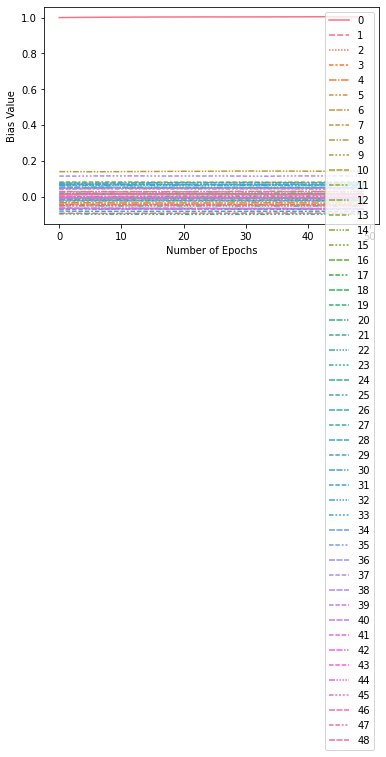

In [ ]:
import os
import torch as th
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


df0 = []
x=0
for root,directory,file in os.walk('/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/experiment'):
  for y in directory:
    for i in file:
      if 'checkpoint' in i:
        y=y.replace('eval','')
        j= th.load(root+y+'/'+i)
        m0 = j['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()
        m0 = pd.DataFrame(m0, columns=[x])
        df0.append(m0)
        x+=1

df=pd.concat(df0,axis=1)
lineplot = sb.lineplot(data=df[:][:49].transpose(), legend="full")
plt.xlabel("Number of Epochs")
plt.ylabel("Bias Value")
plt.scale('log')
lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))
       # print(root+y+i)
#m0 = model_0['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()
#df = pd.concat([df0, df1, df2, df5, df8, df10], axis=1)

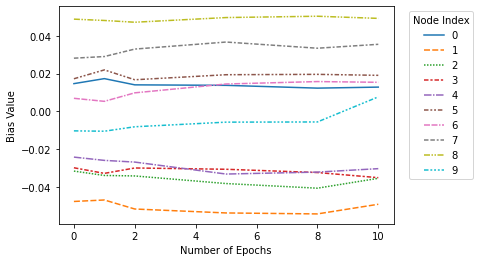

In [ ]:
import tensorflow as tf
import seaborn as sb  # for visualization
import pandas as pd
import numpy
import matplotlib.pyplot as plt

# print(model_0['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item())  # bias for specific node from first transformer encoder layer
m0t1 = model_0['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item()
m0 = model_0['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()     # All biases for this layer

# print(model_1['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item())
m1t1 = model_1['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item()
m1 = model_1['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()

# print(model_2['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item())
m2t1 = model_2['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item()
m2 = model_2['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()

# print(model_5['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item())
m5t1 = model_5['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item()
m5 = model_5['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()

# print(model_8['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item())
m8t1 = model_8['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item()
m8 = model_8['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()

# print(model_10['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item())
m10t1 = model_10['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][0].item()
m10 = model_10['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()

# columns correspond to epoch number
# row data is the bias value - number of the row is the node index in the layer

# df = pd.DataFrame([[m0t1, m1t1, m2t1, m5t1, m8t1, m10t1]], columns=[0, 1, 2, 5, 8, 10])
# df = pd.DataFrame([[m0, m1, m2, m5, m8, m10]], columns=[0, 1, 2, 5, 8, 10])

df0 = pd.DataFrame(m0, columns=[0])
df1 = pd.DataFrame(m1, columns=[1])
df2 = pd.DataFrame(m2, columns=[2])
df5 = pd.DataFrame(m5, columns=[5])
df8 = pd.DataFrame(m8, columns=[8])
df10 = pd.DataFrame(m10, columns=[10])

df = pd.concat([df0, df1, df2, df5, df8, df10], axis=1) # concat along column axis
# df
# df.columns
# df[:][:].values
# df[:].values[:2] # df[col num here].values[bias index goes here]

# sb.lineplot(x=df.columns, y=df[:].values[:]) # x axis is Number of Epochs and y axis is Bias
lineplot = sb.lineplot(data=df[:][:10].transpose(), legend="full")
plt.xlabel("Number of Epochs")
plt.ylabel("Bias Value")
lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))

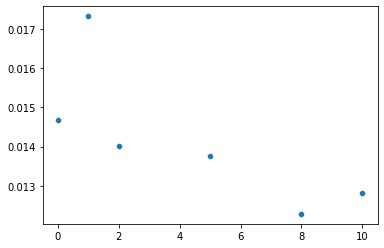

In [ ]:
sb.scatterplot(x=[0, 1, 2, 5, 8, 10], y=[m0t1, m1t1, m2t1, m5t1, m8t1, m10t1]) # x axis is Number of Epochs and y axis is Bias

In [ ]:
#print(model_10.keys())
# print(model_10['model'].keys())
model_keys = model_10['model'].keys()
count_layers = 0
for key in model_keys:
  count_layers += 1
  # if ('transformer' in key and 'weight' in key) or ('transformer' in key and 'bias' in key):
  # if ('transformer' in key and 'bias' in key):
  if ('transformer' in key and 'weight' in key):
    print("\n\n{}\n\n".format(key))
    # break
    # print(model_10['model'][key])
    count_layers += 1

print("Number of transformer layers: {}".format(count_layers))
# print('transformer.encoder.layers.0.self_attn.in_proj_bias')
# print(model_10['model']['transformer.encoder.layers.0.self_attn.in_proj_bias']) # bias for specific layer

## Building the DataFrame & Visualization
**(WARNING: Building DataFrame can take a while, about ~28m on Colab Pro+)**

Load a saved `hdf` file instead of building another DataFrame if you can

## Building Bias DataFrame

In [ ]:
import numpy
import seaborn as sb    # for visualization
import torch as th
import pandas as pd     # To save biases in DataFrame

final_epoch = 300

# init dataframe to hold all bias values
epoch_0 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_0/checkpoint.pth')
bias_0 = epoch_0['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()
bias_0.shape
# df = pd.DataFrame(bias_0, columns=[0])

for current_epoch in range(1,final_epoch+1): # end is exclusive
  checkpointFile = '/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_{}/checkpoint.pth'.format(current_epoch)
  model = th.load(checkpointFile)
  biases = model['model']['transformer.encoder.layers.0.self_attn.in_proj_bias'][:].cpu().numpy()
  
  temp_df = pd.DataFrame(biases, columns=[current_epoch])

  df = pd.concat([df, temp_df], axis=1) # concat along column axis


(768,)

In [ ]:
df[:][:1].transpose() # transpose for visual plot - column is node index and row is epoch

## Visualize Bias Convergence

#### **OPTIONAL:** Load previously saved bias, if you have it

In [ ]:
import pandas as pd
df = pd.read_hdf(r'/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn_biases.h5')

#### Visualize the bias values converging over a number of epochs

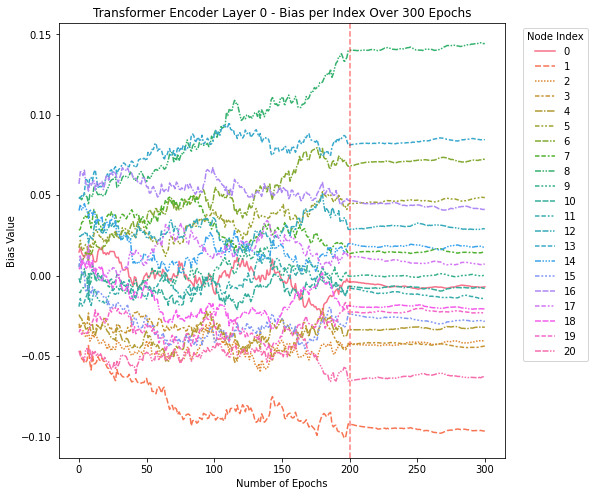

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

lineplot = sb.lineplot(data=df[:][:21].transpose(), legend="full")  # df[:][:final node index here]

plt.rcParams['figure.figsize'] = [8, 8]

# Add vertical line to visualize the approximate area where convergence occurs
plt.axvline(x=200, alpha = 0.5, linestyle="--", color="red")

plt.xlabel("Number of Epochs")
plt.ylabel("Bias Value")
plt.title("Transformer Encoder Layer 0 - Bias per Index Over 300 Epochs")
lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))

Text(0.5, 1.0, 'Transformer Encoder Layer 0 - Bias per Index over 300 Epochs')

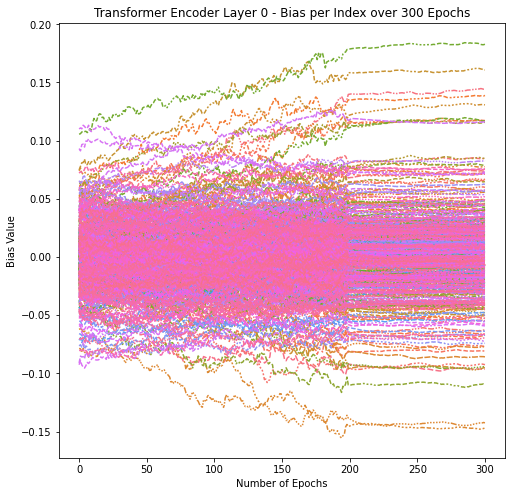

In [ ]:
# All lines in one plot
lineplot = sb.lineplot(data=df[:][:].transpose(), legend=False)

plt.rcParams['figure.figsize'] = [8, 8]

plt.xlabel("Number of Epochs")
plt.ylabel("Bias Value")
plt.title("Transformer Encoder Layer 0 - Bias per Index over 300 Epochs")

## Saving Biases

It can take a while to save large DataFrames as csv file, so we will use `.to_hdf(r'path/file.h5', key='stage', mode='w')` to significantly speed up saving data.

In [ ]:
# Saving biases for transformer.encoder.layers.0.self_attn
df.to_hdf(r'/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn_biases.h5', key='stage', mode='w')

## Building Weight DataFrame

There are 786 nodes and 256 weights per node.

### Build Weight DataFrame for **First** Weight of Each Node

In [ ]:
import numpy
import seaborn as sb    # for visualization
import torch as th
import pandas as pd     # To save weights in DataFrame

final_epoch = 300

# init dataframe to hold all weight values for epoch 0
epoch_0 = th.load('/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/allEpochs/epoch_0/checkpoint.pth')
weight_0 = epoch_0['model']['transformer.encoder.layers.0.self_attn.in_proj_weight'][:].cpu().numpy().reshape(256,768)[0]
# weight_0.reshape(256,768)[0]
weight_df = pd.DataFrame(weight_0, columns=[0])

for current_epoch in range(1,final_epoch+1): # end is exclusive
  checkpointFile = '/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/allEpochs/epoch_{}/checkpoint.pth'.format(current_epoch)
  model = th.load(checkpointFile)
  weights = model['model']['transformer.encoder.layers.0.self_attn.in_proj_weight'][:].cpu().numpy().reshape(256,768)[0]
  
  temp_df = pd.DataFrame(weights, columns=[current_epoch])

  weight_df = pd.concat([weight_df, temp_df], axis=1) # concat along column axis


There are 786 nodes and 256 weights per node.

### Build Weight DataFrame for **Second** Weight of Each Node

In [ ]:
import numpy
import seaborn as sb    # for visualization
import torch as th
import pandas as pd     # To save weights in DataFrame

final_epoch = 300

# init dataframe to hold all weight values for epoch 0
epoch_0 = th.load('/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_0/checkpoint.pth')
weight_0 = epoch_0['model']['transformer.encoder.layers.0.self_attn.in_proj_weight'][:].cpu().numpy().reshape(256,768)[1]
# weight_0.reshape(256,768)[0]
weight1_df = pd.DataFrame(weight_0, columns=[0])

for current_epoch in range(1,final_epoch+1): # end is exclusive
  checkpointFile = '/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/allEpochs/epoch_{}/checkpoint.pth'.format(current_epoch)
  model = th.load(checkpointFile)
  weights = model['model']['transformer.encoder.layers.0.self_attn.in_proj_weight'][:].cpu().numpy().reshape(256,768)[1]
  
  temp_df = pd.DataFrame(weights, columns=[current_epoch])

  weight1_df = pd.concat([weight1_df, temp_df], axis=1) # concat along column axis


## Saving Weights

In [ ]:
weight_df.to_hdf(r'/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn.in_proj_weights_0.h5', key='stage', mode='w')
weight1_df.to_hdf(r'/content/drive/MyDrive/Colab Notebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn.in_proj_weights_1.h5', key='stage', mode='w')

## Visualize Weight Convergence

#### **OPTIONAL:** Load previous saved weights, if you have it.

In [ ]:
weight0_df = pd.read_hdf(r'/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn.in_proj_weights_0.h5')

In [ ]:
weight1_df = pd.read_hdf(r'/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn.in_proj_weights_1.h5')

#### Visualize the weights

**First** weight over 786 nodes

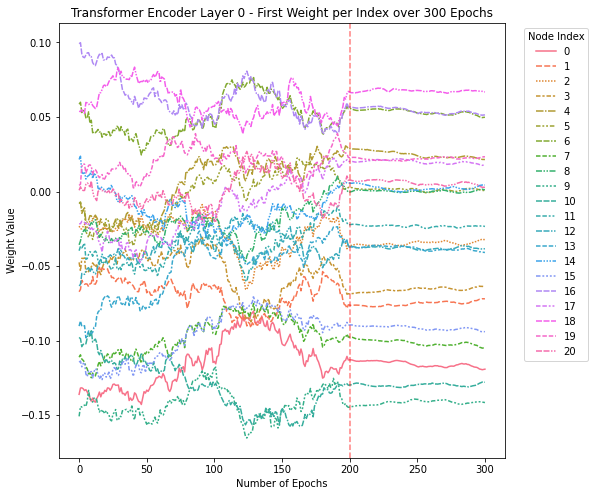

In [ ]:
import matplotlib.pyplot as plt

lineplot = sb.lineplot(data=weight0_df[:][:21].transpose(), legend="full")  # weight_df[:][:final node index here]

plt.rcParams['figure.figsize'] = [8, 8]

# Add vertical line to visualize the approximate area where convergence occurs
plt.axvline(x=200, alpha = 0.5, linestyle="--", color="red")

plt.xlabel("Number of Epochs")
plt.ylabel("Weight Value")
plt.title("Transformer Encoder Layer 0 - First Weight per Index over 300 Epochs")
lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))

Text(0.5, 1.0, 'Transformer Encoder Layer 0 - First Weight per Index over 300 Epochs')

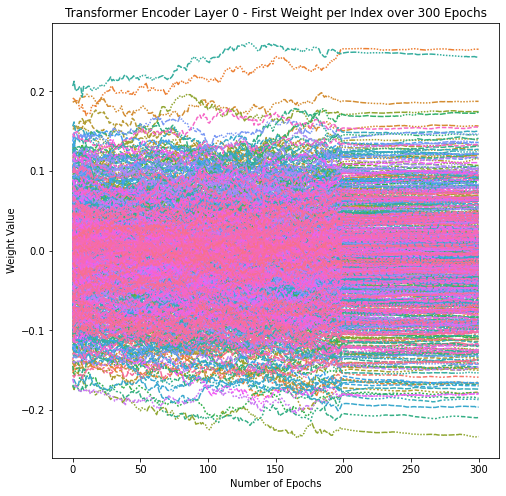

In [ ]:
# All lines in one plot
lineplot = sb.lineplot(data=weight0_df[:][:].transpose(), legend=False)

plt.rcParams['figure.figsize'] = [8, 8]

plt.xlabel("Number of Epochs")
plt.ylabel("Weight Value")
plt.title("Transformer Encoder Layer 0 - First Weight per Index over 300 Epochs")

#### Visualize the weights

**Second** weight over 786 nodes

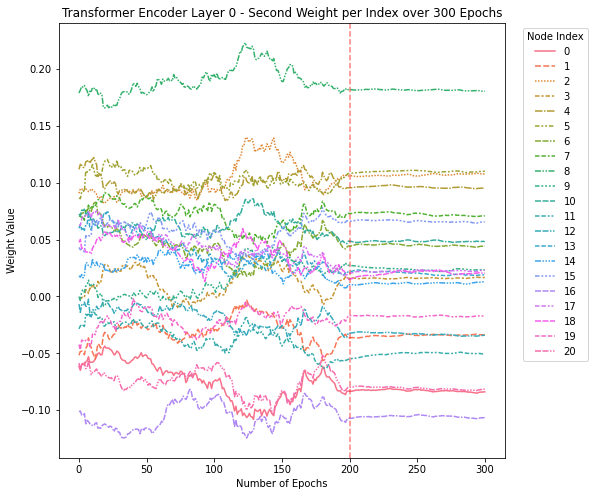

In [ ]:
import matplotlib.pyplot as plt

lineplot = sb.lineplot(data=weight1_df[:][:21].transpose(), legend="full")  # weight_df[:][:final node index here]

plt.rcParams['figure.figsize'] = [8, 8]

# Add vertical line to visualize the approximate area where convergence occurs
plt.axvline(x=200, alpha = 0.5, linestyle="--", color="red")

plt.xlabel("Number of Epochs")
plt.ylabel("Weight Value")
plt.title("Transformer Encoder Layer 0 - Second Weight per Index over 300 Epochs")
lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))

## Experimental: Plot the Derivative of the Biases per epoch

To see the rate of change over the epochs

In [ ]:
biasCol0 = df.to_numpy().reshape(301, 768)[:,100]
biasCol0.shape

(301,)

In [ ]:
poly = numpy.poly1d(biasCol0)
derivative = poly.deriv()

In [ ]:
print(biasCol0[0],
derivative(biasCol0[0])
)

-0.010884938 -0.0017879525603546607


In [ ]:
f = lambda x: derivative(x)

Text(0.5, 1.0, 'Transformer Encoder Layer 0 - Bias per Index over 300 Epochs')

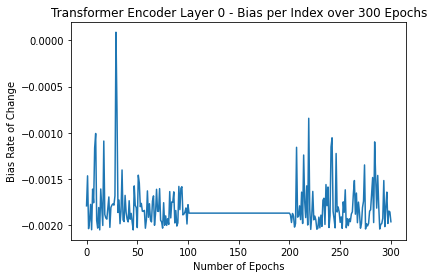

In [ ]:
# sb.lineplot(data=df[:][:].transpose(), legend=False)
sb.lineplot(data=f(biasCol0)[:][:], legend=False)
plt.xlabel("Number of Epochs")
plt.ylabel("Bias Rate of Change")
plt.title("Transformer Encoder Layer 0 - Bias per Index over 300 Epochs")

## Experimental: Plot the Derivative of the Weights per epoch

To see the rate of change over the epochs

In [ ]:
weightCol0 = weight_df.to_numpy().reshape(301, 768)[:,100]
weightCol0.shape

(301,)

In [ ]:
poly_weight = numpy.poly1d(biasCol0)
derivative_weight = poly.deriv()

In [ ]:
f = lambda x: derivative_weight(x)

Text(0.5, 1.0, 'Transformer Encoder Layer 0 - Weight per Index over 300 Epochs')

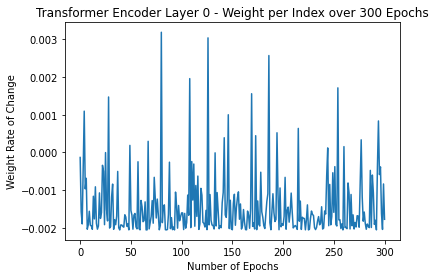

In [ ]:
sb.lineplot(data=f(weightCol0)[:][:], legend=False)
plt.xlabel("Number of Epochs")
plt.ylabel("Weight Rate of Change")
plt.title("Transformer Encoder Layer 0 - Weight per Index over 300 Epochs")

# Visualizing Train/Test Results (DETR R50)



```
"train_loss"
"train_loss_ce"
"train_loss_bbox"
"train_loss_giou"

"test_loss"
"test_loss_ce"
"test_loss_bbox"
"test_loss_giou"
```



In [ ]:
# Never grow a dataframe - https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it

# place values in dict and build dataframe with it
results = {
    "train_loss": [],
    "train_loss_ce": [],
    "train_loss_bbox": [],
    "train_loss_giou": [],
    "test_loss": [],
    "test_loss_ce": [],
    "test_loss_bbox": [],
    "test_loss_giou": []
}

# Iterate through epochs and place values in dict
for num in range(0, 301):
  print("Adding results for epoch: {}...".format(num))
  
  resultsDirectory = "/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/experiment/epoch_{}/log.txt".format(num)
  file = open(resultsDirectory, "r")

  contents = file.read()
  log = ast.literal_eval(contents)

  file.close()

  # Verify it is type dictionary
  # print(type(log))

  for key in results.keys():
    results[key].append(log[key])

print(results)

Adding results for epoch: 0...
Adding results for epoch: 1...
Adding results for epoch: 2...
Adding results for epoch: 3...
Adding results for epoch: 4...
Adding results for epoch: 5...
Adding results for epoch: 6...
Adding results for epoch: 7...
Adding results for epoch: 8...
Adding results for epoch: 9...
Adding results for epoch: 10...
Adding results for epoch: 11...
Adding results for epoch: 12...
Adding results for epoch: 13...
Adding results for epoch: 14...
Adding results for epoch: 15...
Adding results for epoch: 16...
Adding results for epoch: 17...
Adding results for epoch: 18...
Adding results for epoch: 19...
Adding results for epoch: 20...
Adding results for epoch: 21...
Adding results for epoch: 22...
Adding results for epoch: 23...
Adding results for epoch: 24...
Adding results for epoch: 25...
Adding results for epoch: 26...
Adding results for epoch: 27...
Adding results for epoch: 28...
Adding results for epoch: 29...
Adding results for epoch: 30...
Adding results for

In [ ]:
import pandas as pd

df_results = pd.DataFrame.from_dict(results, orient='index').transpose()

In [ ]:
df_results

,train_loss,train_loss_ce,train_loss_bbox,train_loss_giou,test_loss,test_loss_ce,test_loss_bbox,test_loss_giou
0,7.754188,0.324685,0.239493,0.678578,6.111409,0.161181,0.210526,0.627573
1,6.203645,0.167943,0.206588,0.626970,5.424825,0.107538,0.183788,0.569227
2,5.781044,0.140866,0.193973,0.600370,5.941193,0.133936,0.215626,0.632512
3,5.586650,0.122588,0.188839,0.588632,5.109744,0.091410,0.181690,0.551526
4,5.300134,0.109817,0.177329,0.562523,5.222917,0.080789,0.183499,0.567076
...,...,...,...,...,...,...,...,...
296,0.564827,0.004255,0.013723,0.064119,6.148899,0.196736,0.287277,0.644809
297,0.591674,0.004337,0.014632,0.068069,6.136857,0.193476,0.285803,0.645209
298,0.611057,0.004363,0.015189,0.070954,6.161760,0.200808,0.284721,0.647768
299,0.608120,0.004526,0.015250,0.070754,6.123533,0.199240,0.286909,0.645400


Text(0.5, 1.0, 'Train and Test Loss Results for Model with DETR R50 Pretrained Weights')

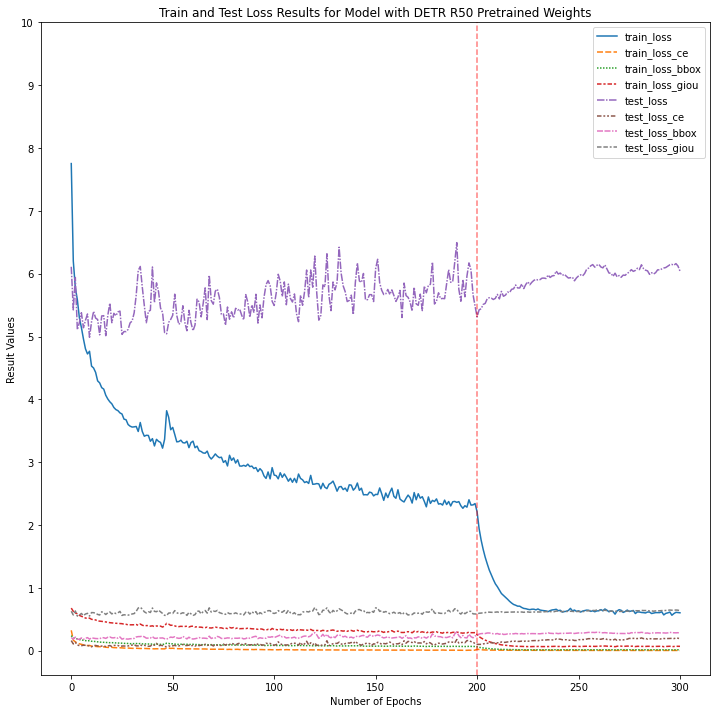

In [ ]:
import matplotlib.pyplot as plt

lineplot = sb.lineplot(data=df_results, legend="full")

plt.yticks([_ for _ in range(0,11)])

plt.rcParams['figure.figsize'] = [12, 12]

# Add vertical line to visualize the approximate area where convergence occurs
plt.axvline(x=200, alpha = 0.5, linestyle="--", color="red")

plt.xlabel("Number of Epochs")
plt.ylabel("Result Values")
plt.title("Train and Test Loss Results for Model with DETR R50 Pretrained Weights")
# lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))

# Visualizing Train/Test Results (DETR R101)



```
"train_loss"
"train_loss_ce"
"train_loss_bbox"
"train_loss_giou"

"test_loss"
"test_loss_ce"
"test_loss_bbox"
"test_loss_giou"
```



In [ ]:
import ast

# Never grow a dataframe - https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it

# place values in dict and build dataframe with it
results = {
    "train_loss": [],
    "train_loss_ce": [],
    "train_loss_bbox": [],
    "train_loss_giou": [],
    "test_loss": [],
    "test_loss_ce": [],
    "test_loss_bbox": [],
    "test_loss_giou": []
}

# Iterate through epochs and place values in dict
for num in range(0, 301):
  print("Adding results for epoch: {}...".format(num))
  
  resultsDirectory = "/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/detr_r101/classNum44_numQueries100/epoch_{}/log.txt".format(num)
  file = open(resultsDirectory, "r")

  contents = file.read()
  log = ast.literal_eval(contents)

  file.close()

  # Verify it is type dictionary
  # print(type(log))

  for key in results.keys():
    results[key].append(log[key])

print(results)

In [ ]:
import pandas as pd

df_results = pd.DataFrame.from_dict(results, orient='index').transpose()

In [ ]:
df_results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

lineplot = sb.lineplot(data=df_results, legend="full")

plt.yticks([_ for _ in range(0,11)])

plt.rcParams['figure.figsize'] = [12, 12]

# Add vertical line to visualize the approximate area where convergence occurs
plt.axvline(x=200, alpha = 0.5, linestyle="--", color="red")

plt.xlabel("Number of Epochs")
plt.ylabel("Result Values")
plt.title("Train and Test Loss Results for Model with DETR R101 Pretrained Weights")
# lineplot.legend(title="Node Index", bbox_to_anchor= (1.03, 1))

# Bias - Data Analysis

We will use pandas and import h5 data for analysis

In [ ]:
import pandas as pd
df = pd.read_hdf(r'/content/drive/MyDrive/ColabNotebooks/PollenImageClassification/transformer.encoder.layers.0.self_attn_biases.h5')

In [ ]:
# each col is a node (768 nodes)
# each row is an epoch (301 epochs)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300
0,0.014669,0.017317,0.014025,0.012416,0.011252,0.013763,0.014840,0.015721,0.012285,0.013921,0.012826,0.008887,0.008428,0.008885,0.014759,0.016781,0.016254,0.017673,0.013718,0.014338,0.012941,0.014292,0.013264,0.015160,0.014937,0.015018,0.014851,0.011899,0.011075,0.011432,0.007832,0.008370,0.004205,0.003374,0.003569,0.004359,0.004660,-0.000872,-0.001244,-0.004073,...,-0.007270,-0.007038,-0.006973,-0.006947,-0.007070,-0.007226,-0.007089,-0.007212,-0.007355,-0.007622,-0.007755,-0.007882,-0.007700,-0.007486,-0.007172,-0.007131,-0.007124,-0.007023,-0.006641,-0.006440,-0.006270,-0.005982,-0.005880,-0.006029,-0.006128,-0.006156,-0.006345,-0.006352,-0.006573,-0.006772,-0.006799,-0.006991,-0.006986,-0.006967,-0.007054,-0.007196,-0.007302,-0.007198,-0.007085,-0.006925
1,-0.047688,-0.046907,-0.051684,-0.052361,-0.054328,-0.053765,-0.052549,-0.043407,-0.054279,-0.058617,-0.049171,-0.054843,-0.054750,-0.053539,-0.050342,-0.052250,-0.053013,-0.051361,-0.053101,-0.053371,-0.055581,-0.057254,-0.057762,-0.060233,-0.061251,-0.060529,-0.063521,-0.065276,-0.058247,-0.061208,-0.060263,-0.061482,-0.062675,-0.063025,-0.062753,-0.062602,-0.062987,-0.061357,-0.064380,-0.066064,...,-0.096967,-0.097417,-0.097426,-0.097505,-0.097706,-0.097854,-0.097917,-0.097771,-0.097490,-0.097043,-0.096780,-0.096234,-0.096196,-0.095976,-0.095971,-0.095971,-0.095698,-0.095565,-0.095455,-0.095302,-0.095459,-0.095613,-0.095594,-0.095442,-0.095412,-0.095540,-0.095778,-0.095796,-0.096002,-0.096181,-0.096374,-0.096318,-0.096232,-0.096243,-0.096258,-0.096327,-0.096164,-0.096388,-0.096548,-0.096448
2,-0.031616,-0.033923,-0.034186,-0.034168,-0.036477,-0.038212,-0.037505,-0.033580,-0.040661,-0.039875,-0.035436,-0.038553,-0.036622,-0.037611,-0.040150,-0.042151,-0.042376,-0.041370,-0.039992,-0.041286,-0.044068,-0.045707,-0.042739,-0.045226,-0.046678,-0.044312,-0.045560,-0.045868,-0.040445,-0.041469,-0.041954,-0.043805,-0.045424,-0.045590,-0.045225,-0.043352,-0.043799,-0.046033,-0.048558,-0.049632,...,-0.042547,-0.042816,-0.042867,-0.042739,-0.042806,-0.042520,-0.042530,-0.042163,-0.041741,-0.041342,-0.041153,-0.040897,-0.040953,-0.040939,-0.041024,-0.040801,-0.040553,-0.040541,-0.040607,-0.040725,-0.041046,-0.041419,-0.041737,-0.041659,-0.041764,-0.041852,-0.041933,-0.041691,-0.041641,-0.041404,-0.041433,-0.041139,-0.040881,-0.040706,-0.040641,-0.040488,-0.040418,-0.040418,-0.040561,-0.040581
3,-0.029860,-0.032825,-0.029970,-0.029595,-0.029295,-0.030653,-0.030143,-0.023193,-0.032382,-0.035014,-0.035094,-0.034883,-0.036919,-0.030500,-0.031303,-0.032127,-0.033288,-0.030920,-0.027444,-0.025676,-0.028305,-0.029233,-0.031583,-0.032870,-0.032621,-0.035190,-0.036066,-0.034135,-0.029976,-0.030783,-0.031192,-0.034089,-0.034700,-0.034919,-0.035412,-0.035491,-0.032164,-0.034608,-0.034159,-0.027395,...,-0.043187,-0.043112,-0.042766,-0.042731,-0.042420,-0.042251,-0.042411,-0.042354,-0.042545,-0.042737,-0.042697,-0.042919,-0.043034,-0.043266,-0.043423,-0.043479,-0.043759,-0.043843,-0.044072,-0.044177,-0.044189,-0.044290,-0.044421,-0.044576,-0.044493,-0.044665,-0.044686,-0.044693,-0.044548,-0.044562,-0.044637,-0.044602,-0.044539,-0.044605,-0.044476,-0.044331,-0.044129,-0.044074,-0.043851,-0.043844
4,-0.024216,-0.025952,-0.026849,-0.029641,-0.030575,-0.033179,-0.033030,-0.031612,-0.032146,-0.030778,-0.030325,-0.036072,-0.036643,-0.034131,-0.031227,-0.032005,-0.032930,-0.030523,-0.031254,-0.031349,-0.032858,-0.034703,-0.035366,-0.037635,-0.038534,-0.039262,-0.039322,-0.040293,-0.032237,-0.033511,-0.035160,-0.037583,-0.040053,-0.040835,-0.040815,-0.038952,-0.039450,-0.041550,-0.044036,-0.044701,...,-0.033253,-0.033510,-0.033465,-0.033453,-0.033606,-0.033421,-0.033464,-0.033148,-0.032690,-0.032173,-0.032050,-0.031676,-0.031757,-0

In [ ]:
df[:][300] # [node/bias][epoch]

0     -0.006925
1     -0.096448
2     -0.040581
3     -0.043844
4     -0.032049
         ...   
763   -0.010966
764    0.045170
765    0.018116
766   -0.028403
767   -0.015587
Name: 300, Length: 768, dtype: float32

In [ ]:
# Describe 768 biases of the 301st epoch
df[:][300].describe()

count    768.000000
mean       0.001326
std        0.030539
min       -0.146859
25%       -0.006731
50%        0.000001
75%        0.010221
max        0.182789
Name: 300, dtype: float64

### Bias Normal Distribution

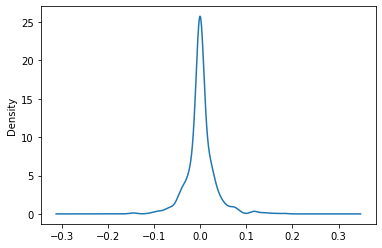

In [ ]:
df[:][300].plot.kde()

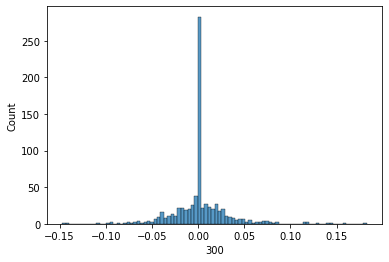

In [ ]:
import seaborn as sb
sb.histplot(df[:][300])

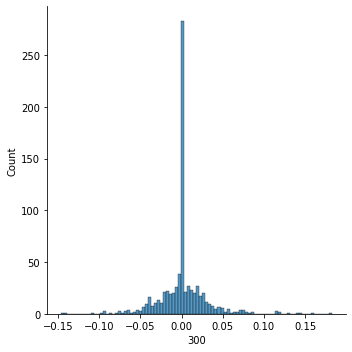

In [ ]:
sb.displot(df[:][300])

In [ ]:
df300 = pd.DataFrame(data= df[:][300])

# quantile = df300.quantile([0.0, 0.9])

df300quant05 = df300 <= df300.quantile(0.05)
print(f"There are {len(df300[df300quant05].dropna())} biases at or below the 5 percentile")

# df300[df300quant05].dropna()

There are 39 biases at or below the 5 percentile


In [ ]:
df300quant95 = df300 >= df300.quantile(0.95)

print(f"There are {len(df300[df300quant95].dropna())} biases at or above the 95 percentile")

# df300[df300quant95].dropna()

There are 39 biases at or above the 95 percentile


# Note to PDF

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/ColabNotebooks/Copy of Working JenFaceBookDETRObjectClassifier20210720.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Copy of Working JenFaceBookDETRObjectClassifier20210720.ipynb to PDF
[NbConvertApp] Support files will be in Copy of Working JenFaceBookDETRObjectClassifier20210720_files/
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier20210720_files
[NbConvertApp] Making directory ./Copy of Working JenFaceBookDETRObjectClassifier2